<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220131_exp8_news_summary_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 8-13. 프로젝트: 뉴스기사 요약해보기
# 추상적 요약과 추출적 요약하기

# Step1. 데이터 수집하기

https://github.com/sunnysai12345/News_Summary



In [62]:
import numpy as np
import pandas as pd

import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [63]:
data.sample(10)

,headlines,text
96302,Can't stop govt from linking bank accounts wit...,The Supreme Court has said the government cann...
32816,Prez repaid attorney for payment to pornstar: ...,"Contradicting claims by Donald Trump, his new ..."
30629,BJP offered money to MLAs after security withd...,Congress leader Ramalinga Reddy on Thursday sa...
70427,Will never go with DMK; they are political ene...,Sidelined AIADMK Deputy General Secretary TTV ...
19426,"Big Bazaar, IndiaÃ¢ÂÂs 1st brand to explore ...","For the first time, you can use voice search t..."
62957,Nasty comments on Aishwarya's weight gain upse...,Abhishek Bachchan has said that nasty things w...
15897,"6 hours on ground, no result is not fair: Shah...",Afghanistan wicketkeeper-batsman Mohammad Shah...
33287,"Trump slams WH press dinner, calls it an embar...",Slamming this year's White House Correspondent...
76521,Pilotless planes could save airlines Ã¢ÂÂ¹2 l...,Pilotless planes would save airlines $35 billi...
5688,J&J announces $5 bn share buyback after losing...,Johnson & Johnson (J&J) on Monday said it plan...


In [64]:
!mkdir -p ~/aiffel/news_summarization/data

In [8]:
# 수동으로 파일 옮김
# csv 파일 같은 경우 깃허브에서 다운로드를 누르면, raw_data가 혼재되어서 눈앞에 나타나는데 
# Ctrl + S를 눌러서 디렉토리를 지정해서 저장을 하면 csv 파일을 다운 받을수 있다.

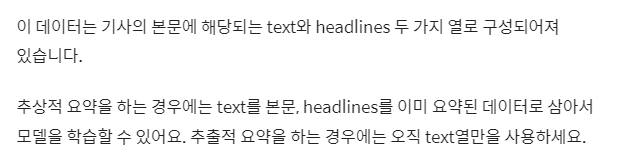

In [65]:
import nltk # nltk import
nltk.download('stopwords')

# 필요한 것들 import 하기
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [6]:
# Total 샘플수는 98401개이다.

In [67]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [68]:
data.tail()

,headlines,text
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


앞서 학습했던 본문 내용과는 다르게 2개의 열로만 구성이 되어있다. 앞서 학습에서는 Text열과 Summary열을 사용하려고 했었는데, 여기에서 headlines이 Summary열의 역할을 하는 것으로 보인다.

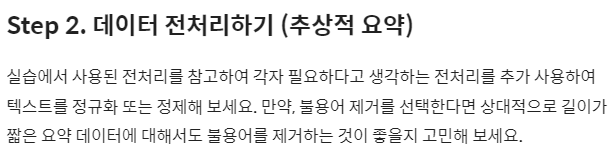

데이터 전처리에서는 

1. 불필요한 데이터를 없애고 
2. 모델을 훈련하기위한 데이터 스플릿 (training set과 test set 나누기)
3. 정수 인코딩으로 텍스트들을 숫자로 만들어 모델에 input을 하여야 한다.

## 1. 불필요한 데이터 트리밍

중복 데이터 소거

In [69]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [10]:
# 각각 중복을 배제한다면, Text에는 98360, headlines에서는 98280의 데이터가 존재한다.

In [70]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾸기
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
# 중복 data가 존재하지 않는다.

Null값 (결측치 데이터) 확인후 제거하기 

In [71]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [19]:
# 다행히 Null값은 존재하지 않는다.

텍스트 정규화와 불용어 제거

In [72]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
# 축약어들의 정규화는 완료하였다.

In [73]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

기본적으로 영어는 소문자로 만들고, html tag 제거, 정규 표현식(import re)을 통하여 각종 특수문자를 제거하는 과정이 필요하다.

아래 코드를 사실상 따와서 사용하는 것이지만, 자연어를 하기 위해서는 외우다시피 해야하는 것 아닐까? 라는 생각이 들었다.

문법적으로 어려운 부분은 없지만, re module의 활용을 잘해야 한다.

In [74]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


데이터 전처리 전과 후를 비교해보기

In [75]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


lms에서 처럼 headlines은 한문장으로 요약하는 의미의 글이다.
그만큼 중심 단어가 담겨야하며, 추상적 요약으로 문장이 만들어질때 문법적으로나 어감으로 자연스러워야 한다.

불용어를 제거하고 할수도 있지만, 그대로 진행할 예정이다.

In [76]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : GPU 런 상태에서 시간이 30분 정도 소요되었다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

Headlines에 대해서 진행

In [77]:
clean_headlines = []

for s in data['headlines']: # 위와 다르게 3분만에 끝남
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  []


In [21]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [22]:
# 결과적으로 null값이 없다 - 다행이다

In [23]:
# 만약 결측치가 있으면 아래 code로 제거를 한다.

# 열로 구성되어 있기에 axis=0을 넣고, 길게 행으로 된 데이터에서 한다면 axis=1로 해야한다. 

# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

## 2. 훈련 데이터와 테스트 데이터 나누기

샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 66
텍스트의 평균 길이 : 58.23730174867833
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553629524196827


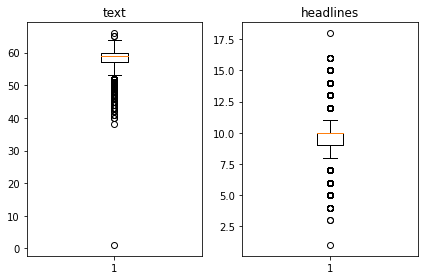

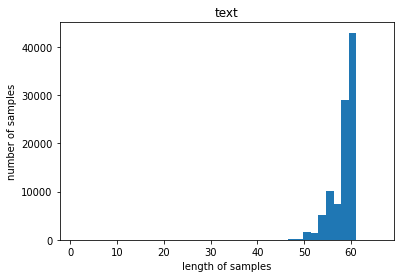

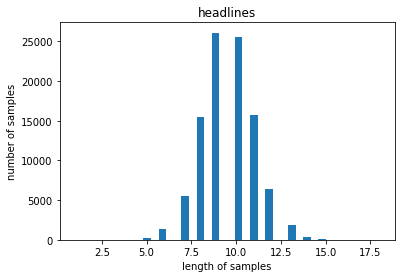

In [78]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 그래프를 보면 text는 주로 60개 내외의 길이를 가지고 있고, headlines의 분포는 비교적 정규분포의 느낌으로 분포되어 있다.
# 우선은 text와 summary의 최대 길이를 정해야 한다.

# 통계적으로 정확하게 접근하기 직전에 임의의 값을 지정해서 해보려고 한다.

In [79]:
text_max_len = 60
headlines_max_len = 10

In [80]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt += 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [81]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9976311508743392
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.7527043513623424


In [82]:
# 비율로 보자면 60이하의 text 샘플은 99프로에 육박하고 headlines 같은 경우에는 75프로이다.

In [83]:
# 정해진 길이보다 길면 제외하는 방법을 사용한다

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 73879


In [84]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
10,UP cousins fed human excreta for friendship wi...,Two minor cousins in Uttar Pradesh's Gorakhpur...,sostoken UP cousins fed human excreta for frie...,UP cousins fed human excreta for friendship wi...
11,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",sostoken 81-yr-old woman conducts physical tra...,81-yr-old woman conducts physical training in ...


In [85]:
# Numpy 타입으로 저장!

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [86]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[59358 66660 19209 ... 27629 27468 54643]


In [87]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [88]:
n_of_val = int(len(encoder_input)*0.2) # 테스트 데이터는 20프로
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14775


In [89]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59104
훈련 레이블의 개수 : 59104
테스트 데이터의 개수 : 14775
테스트 레이블의 개수 : 14775


## 3. 정수 인코딩

In [90]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [91]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 81868
등장 빈도가 6번 이하인 희귀 단어의 수: 60102
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21766
단어 집합에서 희귀 단어의 비율: 73.41329945766356
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2921295322497137


In [92]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거!
# 단어 집합의 크기는 21746에서 어립잡아 20000개로 제한.

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [93]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[19, 39, 2120, 2263, 5034, 832, 32, 6096, 3, 111, 2015, 694, 32, 334, 3, 3665, 7011, 233, 65, 1, 717, 1, 28, 1688, 4042, 13, 189, 77, 2481, 2, 19, 1, 1206, 2469, 4182, 14, 1, 1206, 880, 1, 111, 38, 309, 3, 1206, 1504, 29, 8, 253, 246, 64, 37, 3175, 259, 120], [409, 1018, 8, 1354, 20, 3, 2183, 10, 3, 3579, 1472, 18, 2275, 293, 16, 12, 4348, 43, 5684, 4, 1, 54, 1334, 3914, 1, 3579, 4580, 2, 2121, 32, 176, 1751, 5310, 2, 5089, 18, 2275, 293, 16, 545, 26, 152, 1475, 2, 1, 3579, 79, 25, 1644, 3751, 1, 833, 11, 1056, 11, 13, 2777, 40], [245, 229, 55, 2404, 109, 7, 147, 10, 16, 13, 40, 1512, 2, 1265, 11, 1875, 4, 621, 6, 481, 41, 1036, 16, 38, 2456, 11, 16, 652, 40, 1265, 481, 87, 41, 173, 7012, 1, 3176, 794, 12, 2, 2601, 502, 47, 51, 85, 1875, 3340, 1, 1195, 16, 35]]


In [94]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder_input_train을 입력하여 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [95]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 36900
등장 빈도가 5번 이하인 희귀 단어의 수: 27142
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9758
단어 집합에서 희귀 단어의 비율: 73.55555555555556
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.938687519358916


In [ ]:
# 위 결과로 보아 실제로 희귀단어 등장 비율을 계산하여 제한해야 한다.

# 37018 * 0.08 = 2961 정도 ------> 크게 어림잡아 3000으로 제한.

In [96]:
tar_vocab = 3000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1064, 54, 105, 2588, 126, 87], [1, 1052, 1030, 1459, 1388, 5, 278, 1223], [1, 22, 1041, 3, 2430, 1434, 93, 672, 923], [1, 13, 517, 180, 83, 5], [1, 246, 2159, 4, 436, 8, 1656, 613, 263]]
target
decoder  [[1064, 54, 105, 2588, 126, 87, 2], [1052, 1030, 1459, 1388, 5, 278, 1223, 2], [22, 1041, 3, 2430, 1434, 93, 672, 923, 2], [13, 517, 180, 83, 5, 2], [246, 2159, 4, 436, 8, 1656, 613, 263, 2]]


In [97]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 5
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 59099
훈련 레이블의 개수 : 59099
테스트 데이터의 개수 : 14773
테스트 레이블의 개수 : 14773


In [ ]:
# 패딩하기

# 병렬 처리를 위해 같은 길이로 맞춰주는 패딩 작업

In [98]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [99]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [100]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [101]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

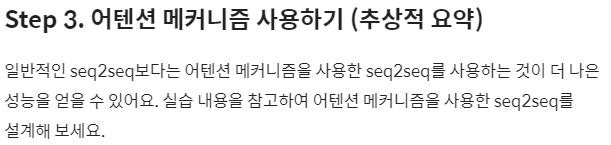

In [102]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [104]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 검증 데이터 손실이 줄어들지 않고 증가하는 현상이 2회되면 학습이 stop
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
231/231 [==============================] - 348s 1s/step - loss: 5.2418 - val_loss: 5.0046
Epoch 2/30
231/231 [==============================] - 311s 1s/step - loss: 4.8861 - val_loss: 4.6841
Epoch 3/30
231/231 [==============================] - 310s 1s/step - loss: 4.5613 - val_loss: 4.4069
Epoch 4/30
231/231 [==============================] - 310s 1s/step - loss: 4.2889 - val_loss: 4.1918
Epoch 5/30
231/231 [==============================] - 309s 1s/step - loss: 4.0865 - val_loss: 4.0495
Epoch 6/30
231/231 [==============================] - 307s 1s/step - loss: 3.9273 - val_loss: 3.9383
Epoch 7/30
231/231 [==============================] - 306s 1s/step - loss: 3.7901 - val_loss: 3.8375
Epoch 8/30
231/231 [==============================] - 306s 1s/step - loss: 3.6656 - val_loss: 3.7606
Epoch 9/30
231/231 [==============================] - 306s 1s/step - loss: 3.5539 - val_loss: 3.6986
Epoch 10/30
231/231 [==============================] - 306s 1s/step - loss: 3.4546 - val_lo

In [105]:
# Earlystopping으로 27 에포크에서 작동이 종료되었다.

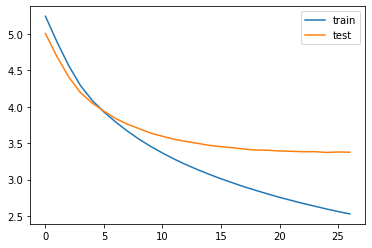

In [106]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [107]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [108]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [109]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [110]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [111]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

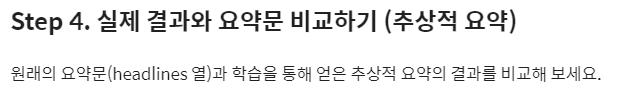

In [135]:
for i in range(50, 100):
    print("원래 문장 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원래 문장 : bjp mp from dinesh kashyap has said that people converting their religion particularly should be barred from benefits of government facilities he further called religious a big problem kashyap later clarified that this was his own thinking adding that the number of religious will be brought down once such an action is taken 
실제 요약 : bar people religion from govt bjp mp 
예측 요약 :  bjp leader urges for not


원래 문장 : a 56 year old indian man diagnosed with end stage heart disease was left with two beating hearts following a heart at hyderabad's apollo hospital doctors decided on keeping both hearts due to size difference with the heart being normal sized while the patient's heart was the size of a small football only about 150 such have been reported 
실제 요약 : indian man gets two after surgery 
예측 요약 :  year old dies after heart surgery in


원래 문장 : alibaba on wednesday debuted its first concept store in china which uses artificial intelligence ai to help users shop the store featur

실제 요약과 예측 요약을 보면 우선 중요한 핵심 키워드어는 다 포착을 하고 있다. 다만 아쉬운점은 마지막 문장 같은 경우에 아예 헛다리를 짚는 경우도 보인다는 것이다.

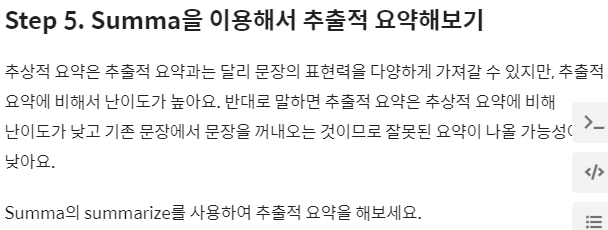

In [114]:
!pip list | grep summa

torchsummary                  1.5.1


In [116]:
!pip install summa # 설치가 안되어 있어 설치

     |████████████████████████████████| 54 kB 1.9 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=bbf201cd468cb77dd5d81e755b5850fadde72d4bbf7153bf292520daaca5a970
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [117]:
import requests
from summa.summarizer import summarize

In [118]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [120]:
print(data[:1500]) # 일부만 출력!

                                              headlines                                               text
0     upGrad learner switches to career in ML & Al w...  Saurav Kant, an alumnus of upGrad and IIIT-B's...
1     Delhi techie wins free food from Swiggy for on...  Kunal Shah's credit card bill payment platform...
2     New Zealand end Rohit Sharma-led India's 12-ma...  New Zealand defeated India by 8 wickets in the...
3     Aegon life iTerm insurance plan helps customer...  With Aegon Life iTerm Insurance plan, customer...
4     Have known Hirani for yrs, what if MeToo claim...  Speaking about the sexual harassment allegatio...
...                                                 ...                                                ...
1495  Have seen Sachin Tendulkar get angry but not M...  India head coach Ravi Shastri has said that he...
1496  Player ensures wife stays dry in rain during A...  Italian tennis player Andreas Seppi ensured hi...
1497  Federer denied entry into locke

In [134]:
for summary, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if summary == 50: # 50개 초과이면 출력
        break
    print("원래 문장 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.45)) # 원문의 40% 정도만 출력 그 이하로 하면 예측문장이 안나옴
    print("\n")

원래 문장 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원래 문장 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bi

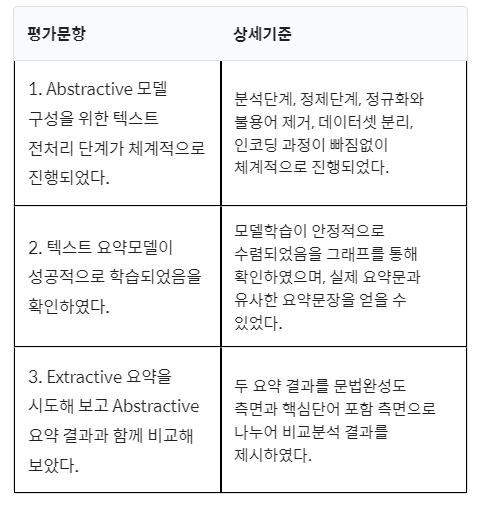

총평 및 요약:

사실 자연어처리가 굉장히 어려웠는데, 이번 익스플로레이션 같은 경우에는 쉬웠다.

왜냐하면, 프로젝트 전 교육과정에서의 약간의 코드 변경만 하면 되었기 때문이다.

현실적으로 여태껏 노드 포함하여 3가지 정도의 자연어 처리를 진행하였는데, RNN 그 이후 LSTM과 GRU 등의 메커니즘 그 이후 어텐션 메커니즘 그리고 seq2seq를 통한 추상적 요약과 summarize 모듈에서의 추출적 요약 모두 경험하게 되었다.

혼공머신 책에는 엄청 짧게나마 소개가 되어 있는데, 이렇게 많은 종류의 다양한 방식들이 있는지 몰랐고, 현재 추가적으로 교재를 구매해서 공부를 해보고자 한다.

아직까지 머릿속에 혼재되어 있는 지식의 정리가 필요한거 같고, 방학기간에 전반적으로 정리를 해봐야겠다는 필요성을 느끼고 있다.

한국어 처리 부분은 더더군다나 영어보다 어려워서 식겁했었는데, 이 부분 또한 한국어 임베딩에 대한 정리가 필수적이다.


루브릭 평가 마지막 세 번째 문항의 비교에서는

# 추상적 요약

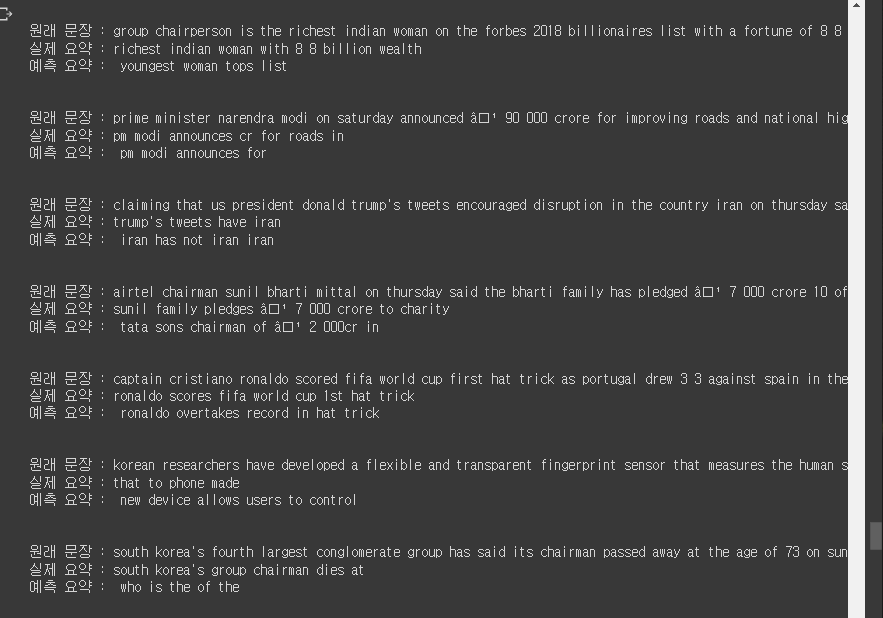

# 추출적 요약

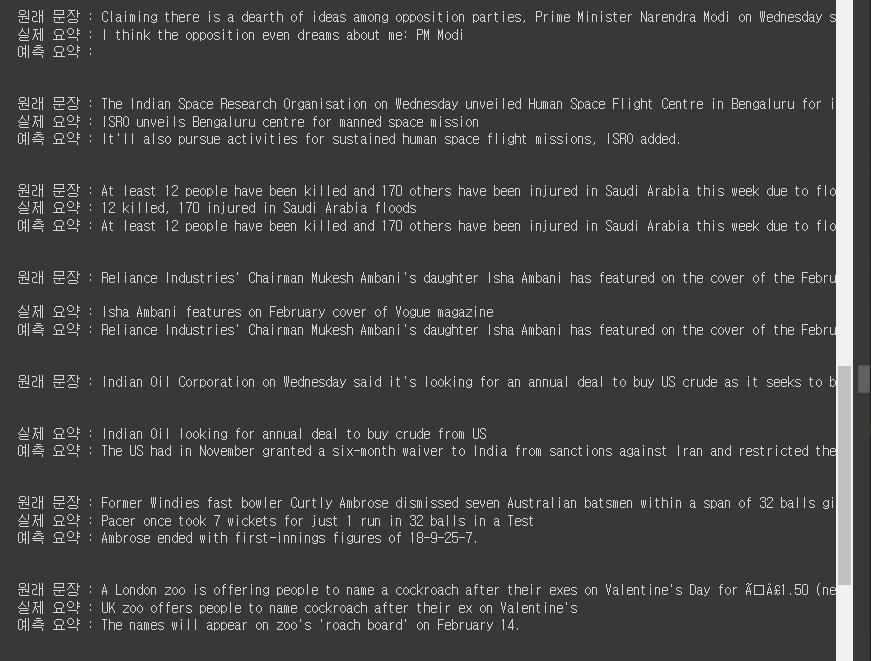

크나큰 차이점이 없었고 일부 문장은 예측의 output이 안나온것도 비슷하였고, 실제 요약과 비교했을때 핵심 키워드 단어만 비슷할뿐 문장 전체가 주는 의미의 유사성은 사실상 찾기가 힘들었다. 

그리고 이상한 글씨가 깨져서 나오는 부분 역시 해결을 못하였는데, 원문에서 손상된 텍스트가 들어가서 학습이 되었으리라는 추측을 해보았다.

마지막, 제시한 부분도 사실 문장에서의 핵심단어들을 카운팅하는 코드를 짜서 유사성을 그래프화 시키려고 했으나 단순히 언급빈도수만 시각화시키는 것이 의미가 없고 (왜냐하면 어순 - 문법이 중요하니까) 그래서 단순히 비교 열거만 해놓았다.

앞으로의 과제는 다음과 같다.

1. 파이썬의 re모듈 숙달, zip함수나 enumerate 같은 것들의 숙달

2. 파편화된 지식들의 정리 

3. exploration에서 해결못한 문장깨짐현상 해결, 유사성을 더 높이고 문법적 에러 부분을 더 면밀하게 해결
(사실 이 부분까지 진행한다면 현업에서 당장 찾는 개발자가 되는것인데...)

